# Model comparisons

In this notebook, we'll take BartPy through its paces using increasingly complex sin wave models.  We'll compare how it performs to two similar models: OLS and catboost.

For the purposes of this exercise, I'm testing out of the box performance.  This makes sense, as part of the value prop of BartPy is it's ability to work well without parameter tuning, but it's possible that the scores of all of the models could be improved with parameter tuning

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import catboost 
from catboost import Pool
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from copy import deepcopy

from bartpy.sklearnmodel import SklearnModel

%matplotlib inline

## Set up models

In [2]:
def fit_catboost(X_train, y_train, X_test, y_test):
    eval_cutoff = len(X_train) // 3
    eval_X, eval_y, train_X, train_y = X_train[:eval_cutoff, :], y_train[:eval_cutoff], X_train[eval_cutoff:, :], y_train[eval_cutoff:]
    catboost_model = catboost.CatBoostRegressor()
    catboost_model.fit(Pool(train_X, train_y), eval_set = Pool(eval_X, eval_y), use_best_model=True)
    pred = catboost_model.predict(X_test)
    score = r2_score(y_test, pred)
    return catboost_model, pred, score

def fit_bartpy(X_train, y_train, X_test, y_test):
    model = SklearnModel(n_samples=1000, n_burn=3, n_trees=500)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    return model, pred, score

def fit_linear_model(X_train, y_train, X_test, y_test):
    rebased_x = np.sin(X_train[:, 0]).reshape(-1, 1)
    linear_model = LinearRegression()
    linear_model.fit(rebased_x, y_train)
    pred = linear_model.predict(np.sin(X_test[:, 0]).reshape(-1, 1))
    score = linear_model.score(np.sin(X_test[:, 0]).reshape(-1, 1), y_test)
    return linear_model, pred, score

kf = KFold(2)

def compare_models(X, y, models_funcs = [fit_bartpy, fit_catboost, fit_linear_model]):
    scores, predictions, trained_models = [], [], []

    for train_index, test_index in kf.split(X):
        trained_models.append([])    
        scores.append([])
        predictions.append([])

        for f in models_funcs:
            model, pred, score = f(X[train_index, :], y[train_index], X[test_index, :], y[test_index])
            trained_models[-1].append(deepcopy(model))
            predictions[-1].append(pred)
            scores[-1].append(score)
    return scores, predictions, trained_models

## One dimensional, single wave

Text(0.5,1,'X v y')

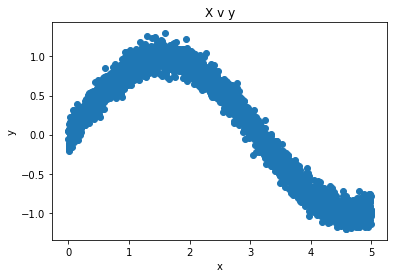

In [3]:
x = np.linspace(0, 5, 3000)
X = pd.DataFrame(x).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [4]:
scores, predictions, models = compare_models(X, y, [fit_bartpy])

Starting burn


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.42it/s]


Starting sampling


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:08<00:00,  7.77it/s]


Starting burn


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.06it/s]


Starting sampling


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.47it/s]


In [6]:
scores

[[0.9801113454465189], [0.9796981103508424]]

In [ ]:
scores, predictions, trained_models = compare_models(X, y)

**As we might expect, all three models are capable of capturing such a simple function.  There's very little difference between the scores or predictions of the models.**

In [30]:
scores

[[0.9798728289609591, 0.9779905518639241, 0.9807614189737301],
 [0.9803561997160845, 0.979246487130466, 0.9812808038622604]]

Text(0,0.5,'Predicted Target')

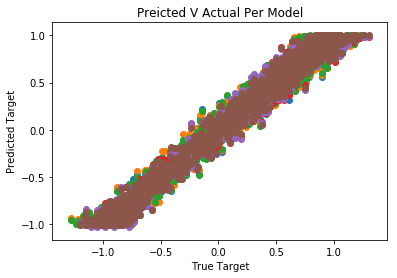

In [31]:
kf = KFold(2)
for p, (train_index, test_index) in zip(predictions, kf.split(X)):
    for m in p:
        plt.scatter(y[test_index], m)
plt.title("Preicted V Actual Per Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")

Text(0.5,1,'Prediction by model by value of X')

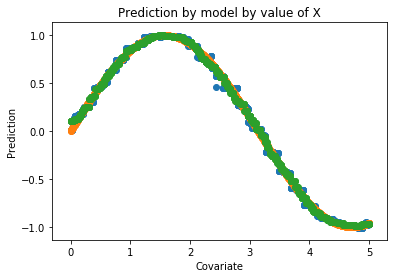

In [28]:
plt.scatter(X[:1500,0],predictions[0][1])
plt.scatter(X[:1500,0],predictions[0][2])
plt.scatter(X[:1500,0],predictions[0][0])
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")

## Single dimension - multiple waves

** To extend our original model, let's add a high frequency cosine wave in our single dimension.  This will make the predicted function change faster and at varying rates across x **

Text(0.5,1,'X v y')

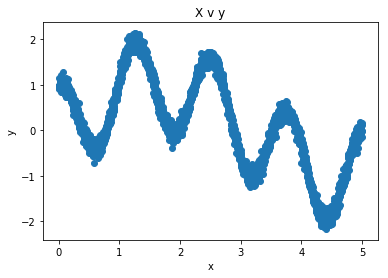

In [23]:
x = np.linspace(0, 5, 3000)
X = pd.DataFrame(x).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0]) + np.cos(5 * X[:, 0])
plt.scatter(X[:, 0], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [ ]:
scores, predictions, trained_models = compare_models(X, y)

** Catboost and BartPy capture this faster moving sin wave pretty nicely, and come up with very similar predictions.  The linear model pretty much treats the cos wave as noise, and fits a curve close to the original one **

In [38]:
scores

[[0.9859508887939317, 0.9754440192208361, 0.48505787845960185],
 [0.9879610023229878, 0.9818666815894833, 0.509902473655678]]

Text(0,0.5,'Predicted Target')

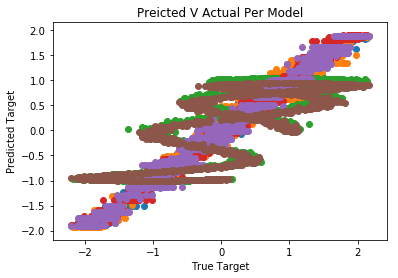

In [39]:
kf = KFold(2)
for p, (train_index, test_index) in zip(predictions, kf.split(X)):
    for m in p:
        plt.scatter(y[test_index], m)
plt.title("Preicted V Actual Per Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")

Text(0.5,1,'Prediction by model by value of X')

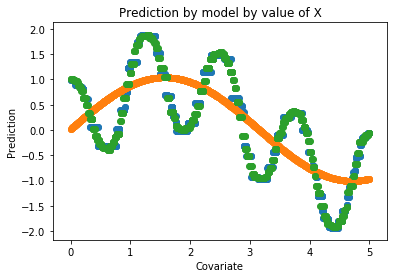

In [40]:
plt.scatter(X[:1500,0],predictions[0][1])
plt.scatter(X[:1500,0],predictions[0][2])
plt.scatter(X[:1500,0],predictions[0][0])
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")

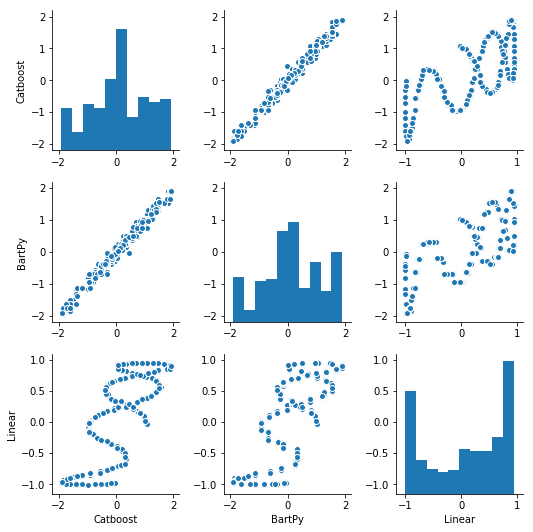

In [41]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["Catboost", "BartPy", "Linear"])
sns.pairplot(p)

## Single dimension - discrete break points

** To make the model more complex, let's add some discrete dumps to make the curve less smooth.  This will test the ability of the models to handle very isolated effects in feature space **

Text(0.5,1,'X v y')

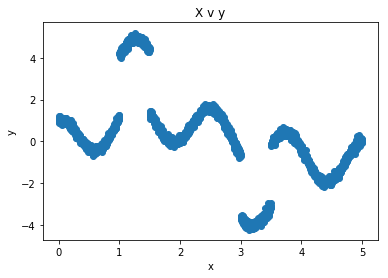

In [49]:
x = np.linspace(0, 5, 3000)
X = pd.DataFrame(x).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0]) + np.cos(5 * X[:, 0])
y[(X[:,0] < 1.5) & (X[:,0] > 1.)] += 3
y[(X[:,0] < 3.5) & (X[:,0] > 3.)] -= 3
plt.scatter(X[:, 0], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [ ]:
scores, predictions, trained_models = compare_models(X, y)

In [52]:
scores

[[0.978236396149402, 0.9885191202572745, 0.2956934596944424],
 [0.9780588821482012, 0.9910936825961947, 0.3214370553664061]]

Text(0,0.5,'Predicted Target')

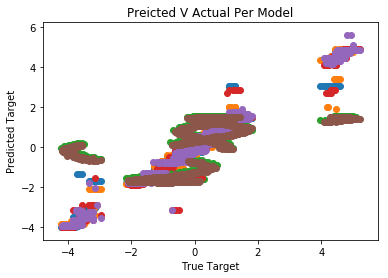

In [51]:
kf = KFold(2)
for p, (train_index, test_index) in zip(predictions, kf.split(X)):
    for m in p:
        plt.scatter(y[test_index], m)
plt.title("Preicted V Actual Per Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")

Text(0.5,1,'Prediction by model by value of X')

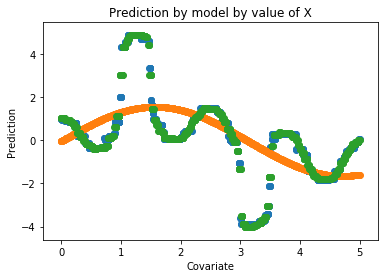

In [53]:
plt.scatter(X[:1500,0],predictions[0][1])
plt.scatter(X[:1500,0],predictions[0][2])
plt.scatter(X[:1500,0],predictions[0][0])
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")

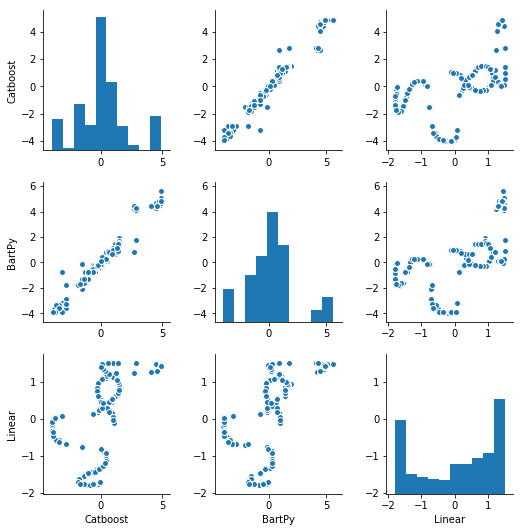

In [54]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["Catboost", "BartPy", "Linear"])
sns.pairplot(p)

# Single meaningful dimension - additional noise dimensions

** It's important for the models to be able to correctly identify features that aren't important.  In this case, we just add normally distributed noise features.  This shouldn't be too difficult a problem to solve **

Text(0.5,1,'X v y')

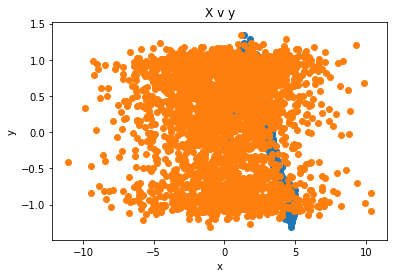

In [5]:
x = np.linspace(0, 5, 3000)
X = np.random.normal(0, 3, size = 3000 * 8).reshape(3000, 8)
X[:, 0] = x
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [6]:
scores, predictions, trained_models = compare_models(X, y)

Starting burn


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.04it/s]


Starting sampling


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:15<00:00,  6.63it/s]


0:	learn: 0.7058179	test: 0.7303266	best: 0.7303266 (0)	total: 143ms	remaining: 2m 23s
1:	learn: 0.6869141	test: 0.7110967	best: 0.7110967 (1)	total: 267ms	remaining: 2m 13s
2:	learn: 0.6709013	test: 0.6948221	best: 0.6948221 (2)	total: 348ms	remaining: 1m 55s
3:	learn: 0.6533730	test: 0.6771896	best: 0.6771896 (3)	total: 420ms	remaining: 1m 44s
4:	learn: 0.6392324	test: 0.6629383	best: 0.6629383 (4)	total: 456ms	remaining: 1m 30s
5:	learn: 0.6239972	test: 0.6475003	best: 0.6475003 (5)	total: 490ms	remaining: 1m 21s
6:	learn: 0.6101722	test: 0.6337271	best: 0.6337271 (6)	total: 523ms	remaining: 1m 14s
7:	learn: 0.5954752	test: 0.6187737	best: 0.6187737 (7)	total: 565ms	remaining: 1m 10s
8:	learn: 0.5803618	test: 0.6033443	best: 0.6033443 (8)	total: 615ms	remaining: 1m 7s
9:	learn: 0.5673807	test: 0.5899669	best: 0.5899669 (9)	total: 657ms	remaining: 1m 5s
10:	learn: 0.5545838	test: 0.5767951	best: 0.5767951 (10)	total: 695ms	remaining: 1m 2s
11:	learn: 0.5411711	test: 0.5630698	best: 0

94:	learn: 0.1302845	test: 0.1361160	best: 0.1361160 (94)	total: 5.21s	remaining: 49.7s
95:	learn: 0.1293061	test: 0.1349970	best: 0.1349970 (95)	total: 5.26s	remaining: 49.5s
96:	learn: 0.1284150	test: 0.1340217	best: 0.1340217 (96)	total: 5.39s	remaining: 50.2s
97:	learn: 0.1274846	test: 0.1329701	best: 0.1329701 (97)	total: 5.44s	remaining: 50.1s
98:	learn: 0.1265216	test: 0.1318071	best: 0.1318071 (98)	total: 5.51s	remaining: 50.1s
99:	learn: 0.1256113	test: 0.1308104	best: 0.1308104 (99)	total: 5.57s	remaining: 50.1s
100:	learn: 0.1246030	test: 0.1297022	best: 0.1297022 (100)	total: 5.62s	remaining: 50s
101:	learn: 0.1239553	test: 0.1289601	best: 0.1289601 (101)	total: 5.66s	remaining: 49.8s
102:	learn: 0.1233450	test: 0.1282492	best: 0.1282492 (102)	total: 5.71s	remaining: 49.7s
103:	learn: 0.1227458	test: 0.1275457	best: 0.1275457 (103)	total: 5.75s	remaining: 49.5s
104:	learn: 0.1220165	test: 0.1266661	best: 0.1266661 (104)	total: 5.79s	remaining: 49.4s
105:	learn: 0.1214164	te

186:	learn: 0.1040106	test: 0.1059580	best: 0.1059580 (186)	total: 9.55s	remaining: 41.5s
187:	learn: 0.1039490	test: 0.1058950	best: 0.1058950 (187)	total: 9.6s	remaining: 41.4s
188:	learn: 0.1038665	test: 0.1058301	best: 0.1058301 (188)	total: 9.64s	remaining: 41.4s
189:	learn: 0.1038482	test: 0.1058189	best: 0.1058189 (189)	total: 9.69s	remaining: 41.3s
190:	learn: 0.1037730	test: 0.1057733	best: 0.1057733 (190)	total: 9.74s	remaining: 41.3s
191:	learn: 0.1036904	test: 0.1056860	best: 0.1056860 (191)	total: 9.79s	remaining: 41.2s
192:	learn: 0.1035631	test: 0.1055735	best: 0.1055735 (192)	total: 9.84s	remaining: 41.1s
193:	learn: 0.1035610	test: 0.1055687	best: 0.1055687 (193)	total: 9.86s	remaining: 41s
194:	learn: 0.1035484	test: 0.1055713	best: 0.1055687 (193)	total: 9.92s	remaining: 40.9s
195:	learn: 0.1034904	test: 0.1055369	best: 0.1055369 (195)	total: 9.97s	remaining: 40.9s
196:	learn: 0.1034684	test: 0.1055062	best: 0.1055062 (196)	total: 10s	remaining: 40.8s
197:	learn: 0.1

278:	learn: 0.1005097	test: 0.1028113	best: 0.1028113 (278)	total: 14.1s	remaining: 36.4s
279:	learn: 0.1004383	test: 0.1028288	best: 0.1028113 (278)	total: 14.1s	remaining: 36.4s
280:	learn: 0.1004382	test: 0.1028303	best: 0.1028113 (278)	total: 14.2s	remaining: 36.2s
281:	learn: 0.1004376	test: 0.1028326	best: 0.1028113 (278)	total: 14.2s	remaining: 36.1s
282:	learn: 0.1004021	test: 0.1028443	best: 0.1028113 (278)	total: 14.2s	remaining: 36.1s
283:	learn: 0.1004013	test: 0.1028467	best: 0.1028113 (278)	total: 14.3s	remaining: 36s
284:	learn: 0.1003906	test: 0.1028361	best: 0.1028113 (278)	total: 14.3s	remaining: 35.9s
285:	learn: 0.1003643	test: 0.1027963	best: 0.1027963 (285)	total: 14.4s	remaining: 35.9s
286:	learn: 0.1003528	test: 0.1027728	best: 0.1027728 (286)	total: 14.4s	remaining: 35.7s
287:	learn: 0.1003186	test: 0.1027513	best: 0.1027513 (287)	total: 14.4s	remaining: 35.7s
288:	learn: 0.1003089	test: 0.1027324	best: 0.1027324 (288)	total: 14.5s	remaining: 35.6s
289:	learn: 

370:	learn: 0.0985604	test: 0.1015431	best: 0.1015394 (368)	total: 19.6s	remaining: 33.3s
371:	learn: 0.0985595	test: 0.1015427	best: 0.1015394 (368)	total: 19.7s	remaining: 33.2s
372:	learn: 0.0985344	test: 0.1015108	best: 0.1015108 (372)	total: 19.8s	remaining: 33.3s
373:	learn: 0.0985234	test: 0.1015013	best: 0.1015013 (373)	total: 19.9s	remaining: 33.2s
374:	learn: 0.0985156	test: 0.1014863	best: 0.1014863 (374)	total: 19.9s	remaining: 33.2s
375:	learn: 0.0985131	test: 0.1014943	best: 0.1014863 (374)	total: 20s	remaining: 33.2s
376:	learn: 0.0985084	test: 0.1014872	best: 0.1014863 (374)	total: 20.1s	remaining: 33.2s
377:	learn: 0.0985056	test: 0.1014941	best: 0.1014863 (374)	total: 20.1s	remaining: 33.1s
378:	learn: 0.0985033	test: 0.1014895	best: 0.1014863 (374)	total: 20.2s	remaining: 33.1s
379:	learn: 0.0984918	test: 0.1014819	best: 0.1014819 (379)	total: 20.3s	remaining: 33.1s
380:	learn: 0.0984907	test: 0.1014817	best: 0.1014817 (380)	total: 20.3s	remaining: 33.1s
381:	learn: 

462:	learn: 0.0973733	test: 0.1009645	best: 0.1009627 (461)	total: 24.5s	remaining: 28.4s
463:	learn: 0.0973631	test: 0.1009679	best: 0.1009627 (461)	total: 24.5s	remaining: 28.3s
464:	learn: 0.0973347	test: 0.1009407	best: 0.1009407 (464)	total: 24.6s	remaining: 28.3s
465:	learn: 0.0973191	test: 0.1009243	best: 0.1009243 (465)	total: 24.6s	remaining: 28.2s
466:	learn: 0.0972543	test: 0.1008803	best: 0.1008803 (466)	total: 24.7s	remaining: 28.2s
467:	learn: 0.0972385	test: 0.1008762	best: 0.1008762 (467)	total: 24.8s	remaining: 28.2s
468:	learn: 0.0972384	test: 0.1008769	best: 0.1008762 (467)	total: 24.8s	remaining: 28.1s
469:	learn: 0.0972248	test: 0.1008811	best: 0.1008762 (467)	total: 24.8s	remaining: 28s
470:	learn: 0.0971427	test: 0.1009036	best: 0.1008762 (467)	total: 24.9s	remaining: 28s
471:	learn: 0.0971427	test: 0.1009043	best: 0.1008762 (467)	total: 24.9s	remaining: 27.9s
472:	learn: 0.0970561	test: 0.1008514	best: 0.1008514 (472)	total: 25s	remaining: 27.9s
473:	learn: 0.09

554:	learn: 0.0954214	test: 0.1006467	best: 0.1006317 (553)	total: 29.1s	remaining: 23.3s
555:	learn: 0.0954104	test: 0.1006519	best: 0.1006317 (553)	total: 29.1s	remaining: 23.3s
556:	learn: 0.0953987	test: 0.1006581	best: 0.1006317 (553)	total: 29.2s	remaining: 23.2s
557:	learn: 0.0953792	test: 0.1006569	best: 0.1006317 (553)	total: 29.3s	remaining: 23.2s
558:	learn: 0.0953762	test: 0.1006564	best: 0.1006317 (553)	total: 29.3s	remaining: 23.1s
559:	learn: 0.0953668	test: 0.1006631	best: 0.1006317 (553)	total: 29.4s	remaining: 23.1s
560:	learn: 0.0953013	test: 0.1006425	best: 0.1006317 (553)	total: 29.4s	remaining: 23s
561:	learn: 0.0952772	test: 0.1006291	best: 0.1006291 (561)	total: 29.5s	remaining: 23s
562:	learn: 0.0952771	test: 0.1006300	best: 0.1006291 (561)	total: 29.5s	remaining: 22.9s
563:	learn: 0.0952665	test: 0.1006345	best: 0.1006291 (561)	total: 29.6s	remaining: 22.9s
564:	learn: 0.0952519	test: 0.1006113	best: 0.1006113 (564)	total: 29.6s	remaining: 22.8s
565:	learn: 0.

646:	learn: 0.0938368	test: 0.1005212	best: 0.1004578 (630)	total: 34.3s	remaining: 18.7s
647:	learn: 0.0938195	test: 0.1005222	best: 0.1004578 (630)	total: 34.3s	remaining: 18.7s
648:	learn: 0.0938099	test: 0.1005175	best: 0.1004578 (630)	total: 34.4s	remaining: 18.6s
649:	learn: 0.0938093	test: 0.1005181	best: 0.1004578 (630)	total: 34.5s	remaining: 18.6s
650:	learn: 0.0937983	test: 0.1005131	best: 0.1004578 (630)	total: 34.6s	remaining: 18.5s
651:	learn: 0.0937962	test: 0.1005147	best: 0.1004578 (630)	total: 34.6s	remaining: 18.5s
652:	learn: 0.0937905	test: 0.1005220	best: 0.1004578 (630)	total: 34.7s	remaining: 18.4s
653:	learn: 0.0937901	test: 0.1005194	best: 0.1004578 (630)	total: 34.7s	remaining: 18.3s
654:	learn: 0.0937844	test: 0.1005211	best: 0.1004578 (630)	total: 34.7s	remaining: 18.3s
655:	learn: 0.0937784	test: 0.1005243	best: 0.1004578 (630)	total: 34.8s	remaining: 18.2s
656:	learn: 0.0936954	test: 0.1005079	best: 0.1004578 (630)	total: 34.9s	remaining: 18.2s
657:	learn

738:	learn: 0.0921977	test: 0.1004739	best: 0.1004535 (701)	total: 41s	remaining: 14.5s
739:	learn: 0.0921324	test: 0.1004608	best: 0.1004535 (701)	total: 41.1s	remaining: 14.4s
740:	learn: 0.0921324	test: 0.1004609	best: 0.1004535 (701)	total: 41.2s	remaining: 14.4s
741:	learn: 0.0921197	test: 0.1004549	best: 0.1004535 (701)	total: 41.2s	remaining: 14.3s
742:	learn: 0.0920545	test: 0.1004566	best: 0.1004535 (701)	total: 41.3s	remaining: 14.3s
743:	learn: 0.0920240	test: 0.1004455	best: 0.1004455 (743)	total: 41.4s	remaining: 14.2s
744:	learn: 0.0920208	test: 0.1004453	best: 0.1004453 (744)	total: 41.5s	remaining: 14.2s
745:	learn: 0.0920208	test: 0.1004459	best: 0.1004453 (744)	total: 41.6s	remaining: 14.1s
746:	learn: 0.0920113	test: 0.1004367	best: 0.1004367 (746)	total: 41.6s	remaining: 14.1s
747:	learn: 0.0919131	test: 0.1004144	best: 0.1004144 (747)	total: 41.7s	remaining: 14.1s
748:	learn: 0.0919068	test: 0.1004171	best: 0.1004144 (747)	total: 41.8s	remaining: 14s
749:	learn: 0.

830:	learn: 0.0903545	test: 0.1003152	best: 0.1002809 (827)	total: 47s	remaining: 9.55s
831:	learn: 0.0903518	test: 0.1003219	best: 0.1002809 (827)	total: 47s	remaining: 9.49s
832:	learn: 0.0902966	test: 0.1003472	best: 0.1002809 (827)	total: 47.2s	remaining: 9.46s
833:	learn: 0.0902672	test: 0.1003451	best: 0.1002809 (827)	total: 47.3s	remaining: 9.4s
834:	learn: 0.0902590	test: 0.1003344	best: 0.1002809 (827)	total: 47.3s	remaining: 9.35s
835:	learn: 0.0902003	test: 0.1003575	best: 0.1002809 (827)	total: 47.4s	remaining: 9.3s
836:	learn: 0.0901180	test: 0.1003708	best: 0.1002809 (827)	total: 47.5s	remaining: 9.24s
837:	learn: 0.0901153	test: 0.1003779	best: 0.1002809 (827)	total: 47.5s	remaining: 9.19s
838:	learn: 0.0901026	test: 0.1003733	best: 0.1002809 (827)	total: 47.6s	remaining: 9.13s
839:	learn: 0.0900939	test: 0.1003686	best: 0.1002809 (827)	total: 47.7s	remaining: 9.08s
840:	learn: 0.0900939	test: 0.1003689	best: 0.1002809 (827)	total: 47.7s	remaining: 9.02s
841:	learn: 0.09

922:	learn: 0.0891810	test: 0.1004716	best: 0.1002809 (827)	total: 52.5s	remaining: 4.38s
923:	learn: 0.0891808	test: 0.1004711	best: 0.1002809 (827)	total: 52.5s	remaining: 4.32s
924:	learn: 0.0891675	test: 0.1004676	best: 0.1002809 (827)	total: 52.7s	remaining: 4.27s
925:	learn: 0.0891654	test: 0.1004689	best: 0.1002809 (827)	total: 52.7s	remaining: 4.21s
926:	learn: 0.0891573	test: 0.1004684	best: 0.1002809 (827)	total: 52.8s	remaining: 4.16s
927:	learn: 0.0891460	test: 0.1004670	best: 0.1002809 (827)	total: 52.9s	remaining: 4.1s
928:	learn: 0.0891360	test: 0.1004749	best: 0.1002809 (827)	total: 53s	remaining: 4.05s
929:	learn: 0.0891212	test: 0.1004828	best: 0.1002809 (827)	total: 53s	remaining: 3.99s
930:	learn: 0.0891023	test: 0.1004870	best: 0.1002809 (827)	total: 53.1s	remaining: 3.94s
931:	learn: 0.0890960	test: 0.1004971	best: 0.1002809 (827)	total: 53.2s	remaining: 3.88s
932:	learn: 0.0890631	test: 0.1004945	best: 0.1002809 (827)	total: 53.2s	remaining: 3.82s
933:	learn: 0.0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.67it/s]


Starting sampling


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:35<00:00,  5.24it/s]


0:	learn: 0.7159431	test: 0.7300378	best: 0.7300378 (0)	total: 558ms	remaining: 9m 17s
1:	learn: 0.6972595	test: 0.7110655	best: 0.7110655 (1)	total: 647ms	remaining: 5m 22s
2:	learn: 0.6798136	test: 0.6935608	best: 0.6935608 (2)	total: 703ms	remaining: 3m 53s
3:	learn: 0.6632856	test: 0.6771745	best: 0.6771745 (3)	total: 756ms	remaining: 3m 8s
4:	learn: 0.6462602	test: 0.6598517	best: 0.6598517 (4)	total: 801ms	remaining: 2m 39s
5:	learn: 0.6312151	test: 0.6447827	best: 0.6447827 (5)	total: 849ms	remaining: 2m 20s
6:	learn: 0.6156395	test: 0.6292040	best: 0.6292040 (6)	total: 901ms	remaining: 2m 7s
7:	learn: 0.6002533	test: 0.6137168	best: 0.6137168 (7)	total: 947ms	remaining: 1m 57s
8:	learn: 0.5846366	test: 0.5978201	best: 0.5978201 (8)	total: 1s	remaining: 1m 50s
9:	learn: 0.5700958	test: 0.5832714	best: 0.5832714 (9)	total: 1.05s	remaining: 1m 43s
10:	learn: 0.5560297	test: 0.5690052	best: 0.5690052 (10)	total: 1.09s	remaining: 1m 38s
11:	learn: 0.5421325	test: 0.5553058	best: 0.5

93:	learn: 0.1224471	test: 0.1387548	best: 0.1387548 (93)	total: 7.04s	remaining: 1m 7s
94:	learn: 0.1213817	test: 0.1376887	best: 0.1376887 (94)	total: 7.11s	remaining: 1m 7s
95:	learn: 0.1204677	test: 0.1367466	best: 0.1367466 (95)	total: 7.19s	remaining: 1m 7s
96:	learn: 0.1193964	test: 0.1356421	best: 0.1356421 (96)	total: 7.26s	remaining: 1m 7s
97:	learn: 0.1184104	test: 0.1346083	best: 0.1346083 (97)	total: 7.31s	remaining: 1m 7s
98:	learn: 0.1175370	test: 0.1337426	best: 0.1337426 (98)	total: 7.38s	remaining: 1m 7s
99:	learn: 0.1170183	test: 0.1332715	best: 0.1332715 (99)	total: 7.44s	remaining: 1m 6s
100:	learn: 0.1162828	test: 0.1325846	best: 0.1325846 (100)	total: 7.5s	remaining: 1m 6s
101:	learn: 0.1155404	test: 0.1318051	best: 0.1318051 (101)	total: 7.55s	remaining: 1m 6s
102:	learn: 0.1150150	test: 0.1313424	best: 0.1313424 (102)	total: 7.62s	remaining: 1m 6s
103:	learn: 0.1143368	test: 0.1306602	best: 0.1306602 (103)	total: 7.68s	remaining: 1m 6s
104:	learn: 0.1137669	tes

186:	learn: 0.0969836	test: 0.1137485	best: 0.1137485 (186)	total: 14s	remaining: 1m
187:	learn: 0.0969655	test: 0.1137412	best: 0.1137412 (187)	total: 14.2s	remaining: 1m 1s
188:	learn: 0.0968992	test: 0.1136895	best: 0.1136895 (188)	total: 14.3s	remaining: 1m 1s
189:	learn: 0.0968876	test: 0.1136924	best: 0.1136895 (188)	total: 14.4s	remaining: 1m 1s
190:	learn: 0.0968549	test: 0.1137106	best: 0.1136895 (188)	total: 14.4s	remaining: 1m 1s
191:	learn: 0.0968003	test: 0.1136827	best: 0.1136827 (191)	total: 14.5s	remaining: 1m 1s
192:	learn: 0.0967475	test: 0.1136766	best: 0.1136766 (192)	total: 14.6s	remaining: 1m 1s
193:	learn: 0.0967000	test: 0.1136531	best: 0.1136531 (193)	total: 14.7s	remaining: 1m
194:	learn: 0.0966871	test: 0.1136343	best: 0.1136343 (194)	total: 14.8s	remaining: 1m
195:	learn: 0.0966598	test: 0.1136341	best: 0.1136341 (195)	total: 14.8s	remaining: 1m
196:	learn: 0.0966503	test: 0.1136361	best: 0.1136341 (195)	total: 14.8s	remaining: 1m
197:	learn: 0.0965656	test:

279:	learn: 0.0936443	test: 0.1109689	best: 0.1109689 (279)	total: 21.8s	remaining: 56.1s
280:	learn: 0.0936422	test: 0.1109644	best: 0.1109644 (280)	total: 21.8s	remaining: 55.9s
281:	learn: 0.0936337	test: 0.1109399	best: 0.1109399 (281)	total: 21.9s	remaining: 55.7s
282:	learn: 0.0935809	test: 0.1108741	best: 0.1108741 (282)	total: 22s	remaining: 55.7s
283:	learn: 0.0935090	test: 0.1108031	best: 0.1108031 (283)	total: 22s	remaining: 55.6s
284:	learn: 0.0934718	test: 0.1107656	best: 0.1107656 (284)	total: 22.1s	remaining: 55.5s
285:	learn: 0.0934693	test: 0.1107574	best: 0.1107574 (285)	total: 22.3s	remaining: 55.6s
286:	learn: 0.0934683	test: 0.1107553	best: 0.1107553 (286)	total: 22.4s	remaining: 55.6s
287:	learn: 0.0934678	test: 0.1107561	best: 0.1107553 (286)	total: 22.4s	remaining: 55.5s
288:	learn: 0.0934407	test: 0.1107584	best: 0.1107553 (286)	total: 22.5s	remaining: 55.5s
289:	learn: 0.0934328	test: 0.1107601	best: 0.1107553 (286)	total: 22.6s	remaining: 55.5s
290:	learn: 0.

371:	learn: 0.0913683	test: 0.1102513	best: 0.1102323 (370)	total: 31.3s	remaining: 52.8s
372:	learn: 0.0913391	test: 0.1102522	best: 0.1102323 (370)	total: 31.4s	remaining: 52.7s
373:	learn: 0.0912899	test: 0.1102324	best: 0.1102323 (370)	total: 31.5s	remaining: 52.7s
374:	learn: 0.0912656	test: 0.1102296	best: 0.1102296 (374)	total: 31.5s	remaining: 52.6s
375:	learn: 0.0912655	test: 0.1102299	best: 0.1102296 (374)	total: 31.6s	remaining: 52.4s
376:	learn: 0.0912550	test: 0.1102202	best: 0.1102202 (376)	total: 31.7s	remaining: 52.4s
377:	learn: 0.0912544	test: 0.1102213	best: 0.1102202 (376)	total: 31.8s	remaining: 52.3s
378:	learn: 0.0912227	test: 0.1102388	best: 0.1102202 (376)	total: 31.9s	remaining: 52.3s
379:	learn: 0.0911965	test: 0.1102236	best: 0.1102202 (376)	total: 32s	remaining: 52.3s
380:	learn: 0.0911915	test: 0.1102221	best: 0.1102202 (376)	total: 32.2s	remaining: 52.3s
381:	learn: 0.0911901	test: 0.1102194	best: 0.1102194 (381)	total: 32.2s	remaining: 52.2s
382:	learn: 

463:	learn: 0.0894877	test: 0.1099317	best: 0.1099317 (463)	total: 39.8s	remaining: 46s
464:	learn: 0.0894762	test: 0.1099352	best: 0.1099317 (463)	total: 39.9s	remaining: 45.9s
465:	learn: 0.0894738	test: 0.1099343	best: 0.1099317 (463)	total: 39.9s	remaining: 45.8s
466:	learn: 0.0894638	test: 0.1099427	best: 0.1099317 (463)	total: 40.1s	remaining: 45.7s
467:	learn: 0.0894476	test: 0.1099535	best: 0.1099317 (463)	total: 40.2s	remaining: 45.6s
468:	learn: 0.0894454	test: 0.1099527	best: 0.1099317 (463)	total: 40.2s	remaining: 45.5s
469:	learn: 0.0894400	test: 0.1099539	best: 0.1099317 (463)	total: 40.3s	remaining: 45.4s
470:	learn: 0.0894238	test: 0.1099475	best: 0.1099317 (463)	total: 40.5s	remaining: 45.4s
471:	learn: 0.0893562	test: 0.1099590	best: 0.1099317 (463)	total: 40.6s	remaining: 45.5s
472:	learn: 0.0893557	test: 0.1099617	best: 0.1099317 (463)	total: 40.7s	remaining: 45.4s
473:	learn: 0.0893455	test: 0.1099676	best: 0.1099317 (463)	total: 40.8s	remaining: 45.3s
474:	learn: 

555:	learn: 0.0880852	test: 0.1098752	best: 0.1098751 (554)	total: 47.4s	remaining: 37.9s
556:	learn: 0.0880337	test: 0.1098795	best: 0.1098751 (554)	total: 47.5s	remaining: 37.8s
557:	learn: 0.0880297	test: 0.1098704	best: 0.1098704 (557)	total: 47.6s	remaining: 37.7s
558:	learn: 0.0880249	test: 0.1098604	best: 0.1098604 (558)	total: 47.7s	remaining: 37.6s
559:	learn: 0.0880185	test: 0.1098648	best: 0.1098604 (558)	total: 47.8s	remaining: 37.6s
560:	learn: 0.0879848	test: 0.1098544	best: 0.1098544 (560)	total: 47.9s	remaining: 37.5s
561:	learn: 0.0879612	test: 0.1098639	best: 0.1098544 (560)	total: 48s	remaining: 37.4s
562:	learn: 0.0879516	test: 0.1098713	best: 0.1098544 (560)	total: 48s	remaining: 37.3s
563:	learn: 0.0879485	test: 0.1098712	best: 0.1098544 (560)	total: 48.1s	remaining: 37.2s
564:	learn: 0.0879480	test: 0.1098726	best: 0.1098544 (560)	total: 48.2s	remaining: 37.1s
565:	learn: 0.0879319	test: 0.1099040	best: 0.1098544 (560)	total: 48.2s	remaining: 37s
566:	learn: 0.08

647:	learn: 0.0862216	test: 0.1100047	best: 0.1098454 (588)	total: 54.3s	remaining: 29.5s
648:	learn: 0.0861765	test: 0.1100481	best: 0.1098454 (588)	total: 54.4s	remaining: 29.4s
649:	learn: 0.0861695	test: 0.1100443	best: 0.1098454 (588)	total: 54.5s	remaining: 29.4s
650:	learn: 0.0861669	test: 0.1100459	best: 0.1098454 (588)	total: 54.6s	remaining: 29.3s
651:	learn: 0.0861458	test: 0.1100439	best: 0.1098454 (588)	total: 54.7s	remaining: 29.2s
652:	learn: 0.0861350	test: 0.1100579	best: 0.1098454 (588)	total: 54.8s	remaining: 29.1s
653:	learn: 0.0861279	test: 0.1100625	best: 0.1098454 (588)	total: 54.9s	remaining: 29s
654:	learn: 0.0861242	test: 0.1100718	best: 0.1098454 (588)	total: 55s	remaining: 28.9s
655:	learn: 0.0860994	test: 0.1100503	best: 0.1098454 (588)	total: 55.1s	remaining: 28.9s
656:	learn: 0.0860967	test: 0.1100607	best: 0.1098454 (588)	total: 55.2s	remaining: 28.8s
657:	learn: 0.0860614	test: 0.1100612	best: 0.1098454 (588)	total: 55.3s	remaining: 28.7s
658:	learn: 0.

739:	learn: 0.0844437	test: 0.1100552	best: 0.1098454 (588)	total: 1m	remaining: 21.2s
740:	learn: 0.0844404	test: 0.1100522	best: 0.1098454 (588)	total: 1m	remaining: 21.1s
741:	learn: 0.0844203	test: 0.1100668	best: 0.1098454 (588)	total: 1m	remaining: 21s
742:	learn: 0.0844187	test: 0.1100707	best: 0.1098454 (588)	total: 1m	remaining: 20.9s
743:	learn: 0.0844054	test: 0.1100662	best: 0.1098454 (588)	total: 1m	remaining: 20.8s
744:	learn: 0.0844044	test: 0.1100660	best: 0.1098454 (588)	total: 1m	remaining: 20.8s
745:	learn: 0.0844043	test: 0.1100659	best: 0.1098454 (588)	total: 1m	remaining: 20.7s
746:	learn: 0.0843955	test: 0.1100875	best: 0.1098454 (588)	total: 1m	remaining: 20.6s
747:	learn: 0.0843908	test: 0.1100941	best: 0.1098454 (588)	total: 1m	remaining: 20.5s
748:	learn: 0.0843818	test: 0.1100973	best: 0.1098454 (588)	total: 1m	remaining: 20.4s
749:	learn: 0.0843668	test: 0.1100784	best: 0.1098454 (588)	total: 1m	remaining: 20.3s
750:	learn: 0.0843654	test: 0.1100822	best: 0

831:	learn: 0.0828293	test: 0.1101292	best: 0.1098454 (588)	total: 1m 4s	remaining: 13.1s
832:	learn: 0.0828130	test: 0.1101365	best: 0.1098454 (588)	total: 1m 4s	remaining: 13s
833:	learn: 0.0827867	test: 0.1101378	best: 0.1098454 (588)	total: 1m 4s	remaining: 12.9s
834:	learn: 0.0827703	test: 0.1101382	best: 0.1098454 (588)	total: 1m 4s	remaining: 12.8s
835:	learn: 0.0827467	test: 0.1101552	best: 0.1098454 (588)	total: 1m 4s	remaining: 12.7s
836:	learn: 0.0827415	test: 0.1101595	best: 0.1098454 (588)	total: 1m 5s	remaining: 12.7s
837:	learn: 0.0827142	test: 0.1101519	best: 0.1098454 (588)	total: 1m 5s	remaining: 12.6s
838:	learn: 0.0827141	test: 0.1101526	best: 0.1098454 (588)	total: 1m 5s	remaining: 12.5s
839:	learn: 0.0826843	test: 0.1101859	best: 0.1098454 (588)	total: 1m 5s	remaining: 12.4s
840:	learn: 0.0826531	test: 0.1101842	best: 0.1098454 (588)	total: 1m 5s	remaining: 12.3s
841:	learn: 0.0826334	test: 0.1101998	best: 0.1098454 (588)	total: 1m 5s	remaining: 12.2s
842:	learn: 

923:	learn: 0.0813129	test: 0.1103241	best: 0.1098454 (588)	total: 1m 9s	remaining: 5.72s
924:	learn: 0.0812521	test: 0.1103416	best: 0.1098454 (588)	total: 1m 9s	remaining: 5.65s
925:	learn: 0.0812509	test: 0.1103437	best: 0.1098454 (588)	total: 1m 9s	remaining: 5.57s
926:	learn: 0.0812216	test: 0.1103311	best: 0.1098454 (588)	total: 1m 9s	remaining: 5.5s
927:	learn: 0.0812216	test: 0.1103312	best: 0.1098454 (588)	total: 1m 9s	remaining: 5.42s
928:	learn: 0.0812214	test: 0.1103316	best: 0.1098454 (588)	total: 1m 9s	remaining: 5.34s
929:	learn: 0.0812121	test: 0.1103178	best: 0.1098454 (588)	total: 1m 9s	remaining: 5.26s
930:	learn: 0.0812024	test: 0.1103075	best: 0.1098454 (588)	total: 1m 10s	remaining: 5.19s
931:	learn: 0.0812022	test: 0.1103086	best: 0.1098454 (588)	total: 1m 10s	remaining: 5.11s
932:	learn: 0.0811943	test: 0.1103000	best: 0.1098454 (588)	total: 1m 10s	remaining: 5.03s
933:	learn: 0.0811925	test: 0.1103032	best: 0.1098454 (588)	total: 1m 10s	remaining: 4.96s
934:	le

In [7]:
scores

[[0.9772467096545159, 0.9781451797138636, 0.9807508568770892],
 [0.9776521926493782, 0.977883830107735, 0.9801736500968079]]

Text(0,0.5,'Predicted Target')

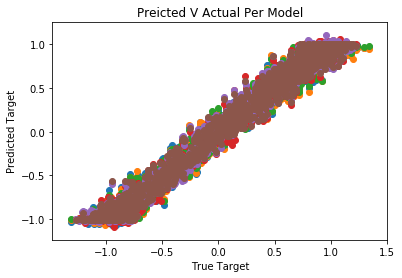

In [8]:
kf = KFold(2)
for p, (train_index, test_index) in zip(predictions, kf.split(X)):
    for m in p:
        plt.scatter(y[test_index], m)
plt.title("Preicted V Actual Per Model")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")

Text(0.5,1,'Prediction by model by value of X')

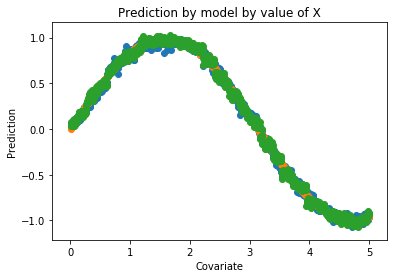

In [9]:
plt.scatter(X[:1500,0],predictions[0][1])
plt.scatter(X[:1500,0],predictions[0][2])
plt.scatter(X[:1500,0],predictions[0][0])
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")

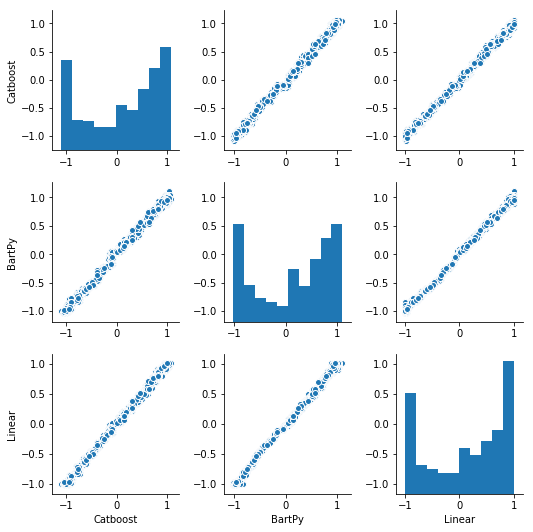

In [10]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["Catboost", "BartPy", "Linear"])
sns.pairplot(p)

## Mixture of multiple meaningful dimensions and noise dimensions

** Both catboost and BartPy have performed well with noise dimensions and rapidly moving targets, let's combine them to make a relatively difficult test for tree models **

Text(0.5,1,'X v y')

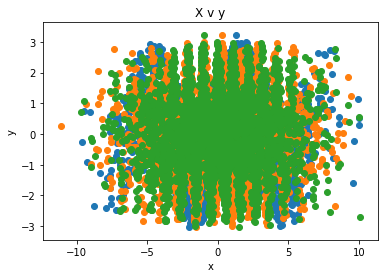

In [3]:
X = np.random.normal(0, 3, size = 3000 * 8).reshape(3000, 8)
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0]) + np.sin(5 * X[:, 1]) + np.cos(-6 * X[:, 3])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.scatter(X[:, 3], y)

plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")


In [ ]:
scores, predictions, trained_models = compare_models(X, y, [fit_bartpy])

Starting burn


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.25it/s]


Starting sampling


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:21<00:00,  2.27it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.35it/s]


Starting sampling


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 481/1000 [06:36<07:07,  1.21it/s]

In [13]:
scores

[[0.5464956574257351, 0.5697758802204275, 0.32396717209436254],
 [0.532104135246146, 0.656279388545232, 0.3370101754372119]]

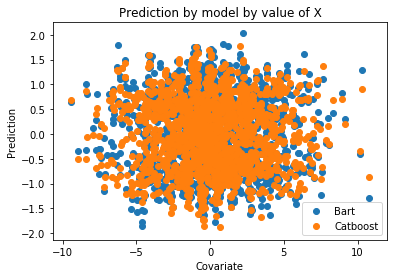

In [17]:
plt.scatter(X[:1500,3],predictions[0][1], label = "Bart")
#plt.scatter(X[:1500,3],predictions[0][2], label = "Ols")
plt.scatter(X[:1500,3],predictions[0][0], label = "Catboost")
plt.ylabel("Prediction")
plt.xlabel("Covariate")
plt.title("Prediction by model by value of X")
plt.legend(loc = "best")

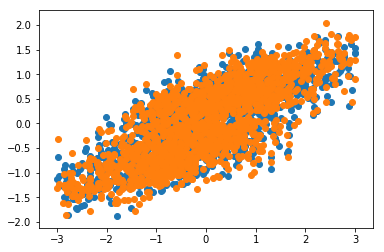

In [18]:
plt.scatter(y[:1500],predictions[0][0], label = "Catboost")
plt.scatter(y[:1500],predictions[0][1], label = "Catboost")
#plt.scatter(y[:1500],predictions[0][2], label = "Catboost")

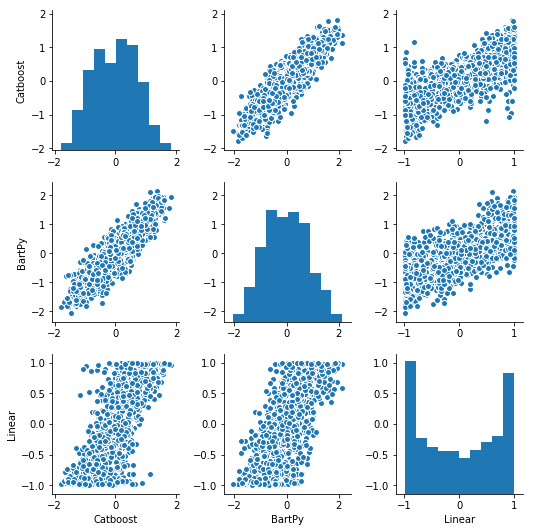

In [16]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["Catboost", "BartPy", "Linear"])
sns.pairplot(p)